# Feature Extraction
## Simplifying the Problem
Given the time and resource constraints, instead of estimating the probability of a threat in each zone, we will solve a smaller problem: we will solve a binary classification problem where the positive class is that where any threat exists in the zones given by r_leg = [7,8,9,10,11,12,13,14,15]. These zone correspond to the lower body of the subjects .  I have chosen these zones because one would expect lower variation in the shape and size of the legs than in the shape and size of the torso.  Additionally, the reads around the area of the arms tends to be noisy/blurry.  Presumably, this may be cause the arms represent a smaller surface area rotating faster than the rest of the body.  The arms are further away from the rotational axis ( axis from the crown of the head to the floor) than other body parts. 

## Create Keras Sequencer

In [1]:
import HelperFuncs as hfuncs
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.data_utils import Sequence
import h5py
import os

BATCH_SIZE = 1
FINAL_WIDTH = hfuncs.FINAL_WIDTH
FINAL_HEIGHT = hfuncs.FINAL_HEIGHT
CHANNELS = hfuncs.CHANNELS
ZONES = hfuncs.ZONES
ANGLES = hfuncs.ANGLES

#Create directories for sequencer function if they don't exist
for d in ['temp/train_scan/','temp/test_scan/','temp/val_scan/']:
    if not os.path.isdir(d):
        print("Created directory: {}".format(d))
        os.makedirs(d)
        
class ScanSequencer(Sequence):
    '''
    Keras sequencer downloads HDF5 files from S3 and returns data in batches
    
    '''
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan"):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((BATCH_SIZE,ANGLES,FINAL_WIDTH,FINAL_HEIGHT,CHANNELS))
        y_train = np.zeros((BATCH_SIZE,ZONES))
        
        j=0
        for i in range(idx*BATCH_SIZE,(idx+1)*BATCH_SIZE):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:,:]
                y_train[j,:] = f['/labels'].value
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train
    
class LegScanSequencer(Sequence):
    '''
    Sequencer class adapted from class above.  This class, however, aggregates data for zones given 
    by "r_leg."  In this project, instead of giving multi-label probabilities, we will solve the problem
    of identifying the existence of ANY threat in the body from the waist down.  
    
    '''
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan",batch_size=BATCH_SIZE):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
        self.batch_size = batch_size
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((self.batch_size,ANGLES,FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
        y_train = np.zeros((self.batch_size,1))
        s_weights = np.zeros((self.batch_size))
        j=0
        for i in range(idx*self.batch_size,(idx+1)*self.batch_size):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:FINAL_HEIGHT*3//5,:]
                r_leg = [7,8,9,10,11,12,13,14,15]
                r_y = np.amax(f['/labels'].value[r_leg])
                y_train[j,:] = r_y
                s_weights[j] = np.squeeze(r_y*0 + 1) #np.squeeze(r_y + (-1 * r_y + 1)*2)
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train,s_weights



Setting demo environment variables...


Using TensorFlow backend.


## Feature Extraction Using a Pre-Trained Model

In [2]:
import numpy as np
from keras.layers import Input,Flatten,Dense,Concatenate,Dropout,concatenate,GlobalMaxPool2D,GlobalAveragePooling1D
from keras.models import Model
from datetime import datetime
from keras.metrics import binary_accuracy
from keras.layers.wrappers import TimeDistributed
from keras.losses import binary_crossentropy
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers.core import Lambda
import tensorflow as tf
from keras import backend as K
#from keras.applications.vgg19 import VGG19

def ToRGB(x):
    max_v = tf.reduce_max(x)
    min_v = tf.reduce_min(x)
    max_rgb = tf.constant(255,dtype=x.dtype)
    min_rgb = tf.constant(255//2,dtype=x.dtype)
    x = tf.add(tf.floordiv(tf.multiply(tf.subtract(x,min_v),tf.subtract(max_rgb,min_rgb)),tf.subtract(max_v,min_v)),min_rgb)
    return x
def ToGreyScale(x):
    #Divide RGB into 3
   # scalar = tf.constant(3,dtype=x.dtype)
    #x = tf.floordiv(x,scalar)
    shape = x.get_shape()
    #assume channel_last
    mult = [[1 for d in shape[:-1]],[3]]
    mult = [val for sublist in mult for val in sublist]
    return tf.tile(x,mult)
def ToNewShape(x):
    ndim = len(x.shape)
    if ndim == 5:
        return tf.reverse(tf.transpose(x,[0,1,3,2,4]),[-3])
    elif ndim == 4:
        return tf.reverse(tf.transpose(x,[0,2,1,3]),[-3])
    else:
        raise ValueError("Unexpected number of dims!")
def ReduceTimeDist(x):
    shape = x.get_shape()
    final = int(shape[-1] * shape[-2])
    return tf.reshape(x,[tf.shape(x)[0],final])

def getSingleLegModel():
    #Single model image
    input_img = Input(shape=(FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
    
    #preprocess and extract channels
    input_img_pp = Lambda(ToRGB)(input_img)
    input_img_pp = Lambda(ToGreyScale)(input_img_pp)
    input_img_pp = Lambda(preprocess_input)(input_img_pp)
    input_img_pp = Lambda(ToNewShape)(input_img_pp)
    
    #Load resnet
    incep = InceptionV3(include_top=False,
                          weights='imagenet',
                          input_tensor=None,
                          input_shape=(FINAL_HEIGHT*3//5,FINAL_WIDTH,3),
                          pooling='None')
    for l in incep.layers:
        l.trainable=False
    
    #Take off top and output feaatures at various levels of complexity
    reduced_net = Model(incep.input,[incep.get_layer('mixed0').output,
                                     incep.get_layer('mixed1').output,
                                     incep.get_layer('mixed2').output,
                                    incep.get_layer('mixed3').output,
                                    incep.get_layer('mixed4').output,
                                    incep.get_layer('mixed5').output,
                                    incep.get_layer('mixed6').output,
                                    incep.get_layer('mixed7').output,
                                    incep.get_layer('mixed8').output,
                                    incep.get_layer('mixed9').output])
    
    #MaxPool and concatenation
    output = reduced_net(input_img_pp)
    output_ary = []
    for o in output:
        output_ary.append(GlobalMaxPool2D()(o))
    output = Concatenate()(output_ary)
    #Finalize intermediate model
    intermediate_model = Model(input_img,output)
    
    #Time distributed model
    input_scan = Input(shape=(ANGLES,FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
    sequenced_model = TimeDistributed(intermediate_model)(input_scan)
    sequenced_model._uses_learning_phase = True
    
    #Finally,concatenate time dist outputs
    out = Lambda(ReduceTimeDist)(sequenced_model)
    
    #Complete model
    model = Model(input_scan,out)
    
    try:
        return model
    finally:
        del intermediate_model,incep,reduced_net

### Pre-Processing
In order to use a pre-trained model, we must consider the dataset on which it was trained and the pre-processing that it itself uses.  For this project we chose to use the InceptionV3 model because it tends to work well with blurry images.  This model was pre-trained on the ImageNet dataset. These images have 3 channels encoded in standard RGB format with values in [0,255].

Below, we will convert the readings into RGB such that the lowest reading (i.e 7000, which corresponds to background noise) ends up close to zero.  This is desirable because the preprocessing for InceptionV3 involves transforming the values to have zero mean and to be distributed between -1 and 1.  In this way, the 7000 background reading will end up close to 0, while more meaningful readings will lie farther from the mean.  If we think about this in terms of forward and backward propagation, any weight multiplied by 0 will yield zero.  This essentially kills the information propagation very early on.  This is exactly what we want for those many pizels belonging to the background.

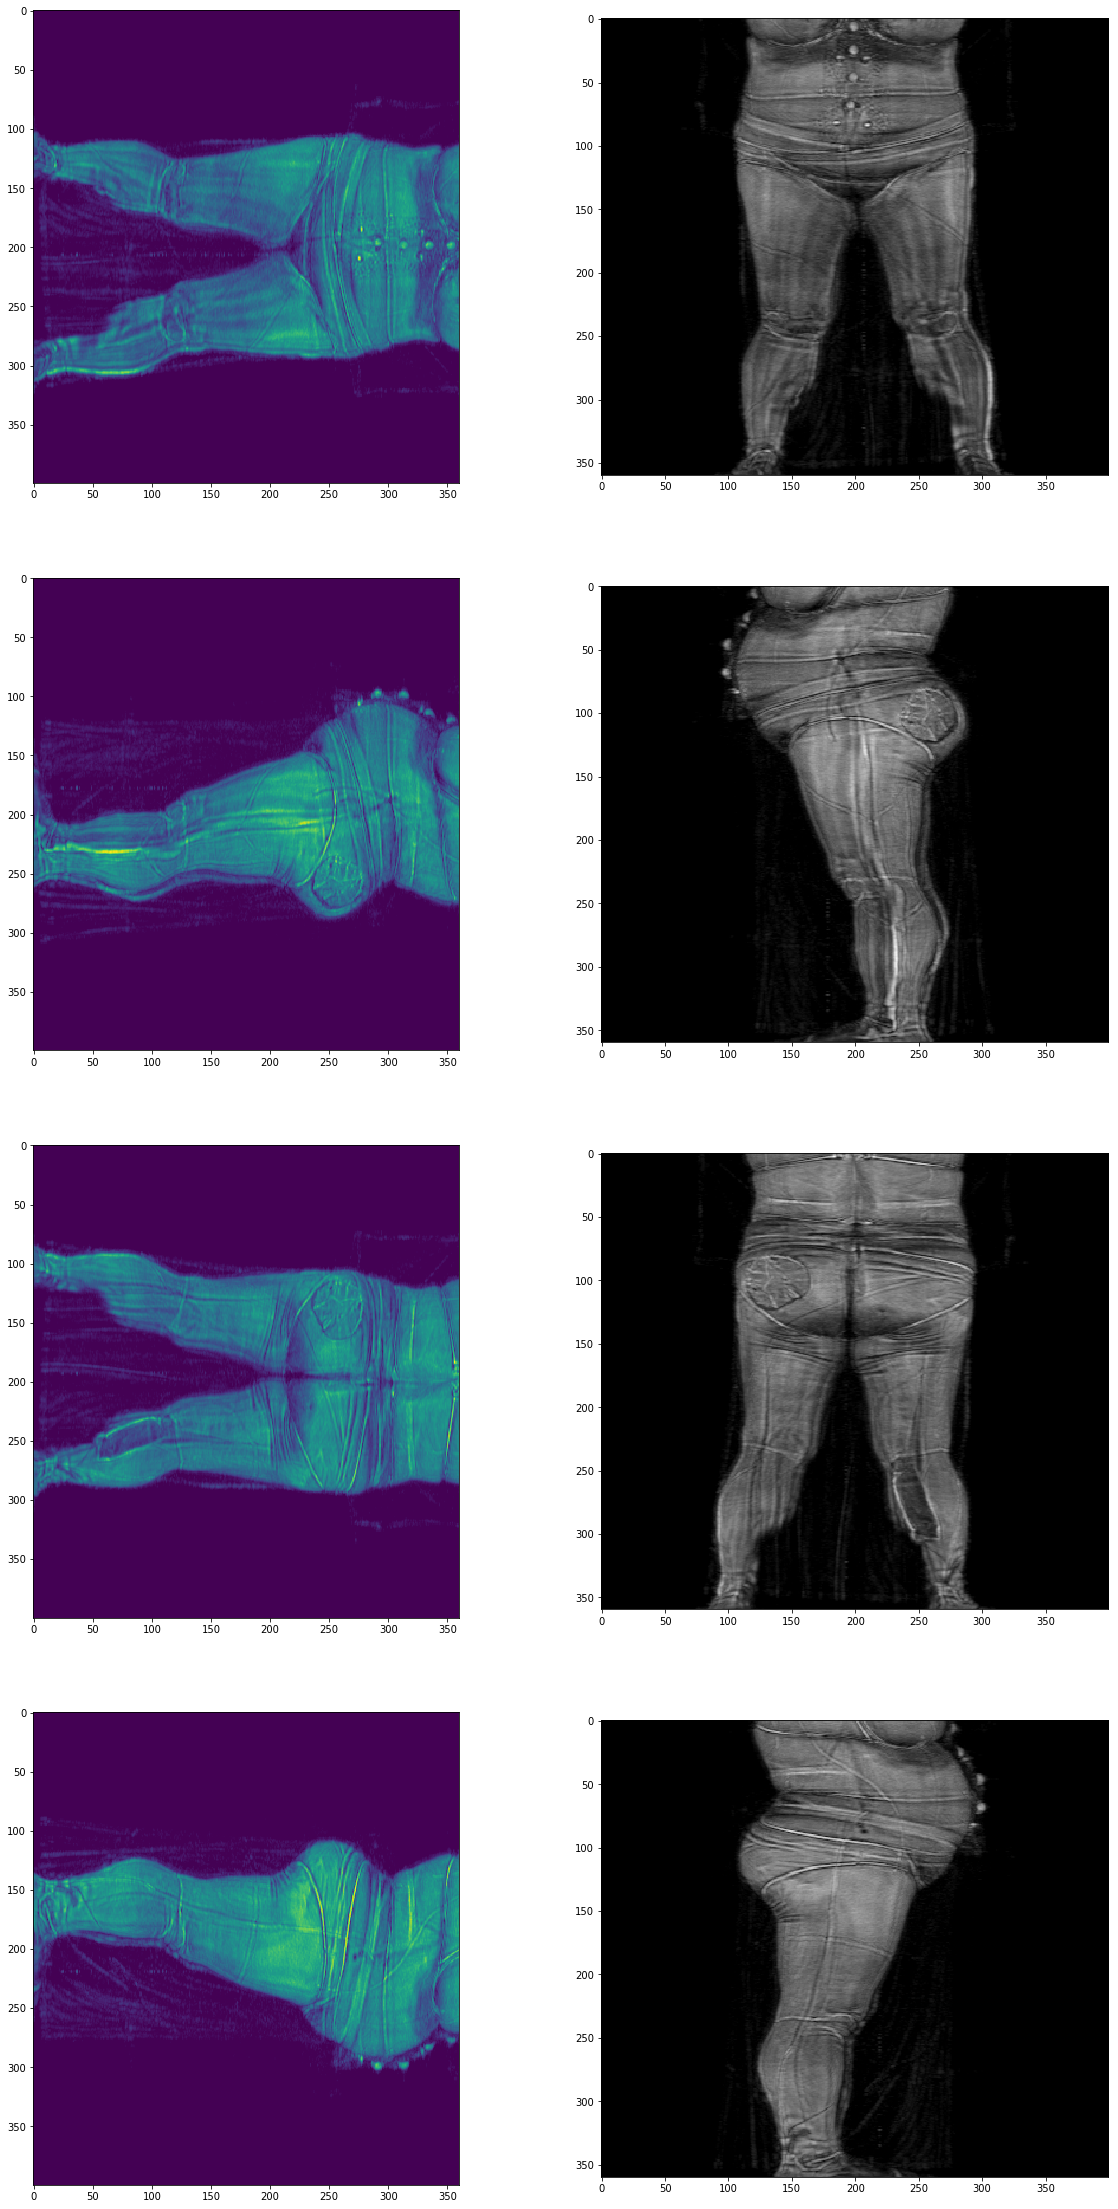

In [3]:
from matplotlib import pyplot as plt
import numpy as np
% matplotlib inline

def getPreProcessingModel():
    # Single image model 
    input_img = Input(shape=(FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
    
    # Preprocess and extract channels
    input_img_pp = Lambda(ToRGB)(input_img)
    input_img_pp = Lambda(ToGreyScale)(input_img_pp)
    input_img_pp = Lambda(preprocess_input)(input_img_pp)
    input_img_pp = Lambda(ToNewShape)(input_img_pp)
    
    # Finalize intermediate model
    intermediate_model = Model(input_img,input_img_pp)
    
    # Time distributed model
    input_scan = Input(shape=(ANGLES,FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
    sequenced_model = TimeDistributed(intermediate_model)(input_scan)
    
    # Complete model
    model = Model(input_scan,sequenced_model)
    
    try:
        return model
    finally:
        del intermediate_model
                  
pp_model = getPreProcessingModel()
                
# Initialize train sequencer
mode ="train_scan"
num_batches_train = 3
train_seq = LegScanSequencer(num_batches_train,hfuncs.CLEAN_DATA_BUCKET,mode=mode)
                
# Viualize pre-processing
X, y, s = train_seq.__getitem__(0)
X_pp = pp_model.predict(X)
                  
fig, axes = plt.subplots(4,2,figsize=(20,40))               
 
i = 0   
for j in np.arange(0,16,4):
      axes[i,0].imshow(X[0,j,:,:,0])
      axes[i,1].imshow(X_pp[0,j,:,:,:])
      i += 1


## Feature Extraction

In [4]:
# Use model as a feature extractor and use traditional ML approach to determine whether features have any predictive power
import h5py
from keras import backend as K

TEMP_DIR = hfuncs.TEMP_DIR
# Bucket with clean data
UPLOAD_BUCKET = hfuncs.CLEAN_DATA_BUCKET #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

# Initialize train sequencer
mode ="train_scan"
num_batches_train = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE 
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)

# Initialize validation sequencer
mode = "val_scan"
num_batches_val = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE 
val_seq = LegScanSequencer(num_batches_val,UPLOAD_BUCKET,mode=mode)


# Create function that creates data set by extracting features using model
def CreateFeatureDataSet(model,dir_name = 'fullfeatureextraction',max_batches=1200):
    # Get model and output size
    output_size = model.output_shape[1]
    
    # Variables to iterate over
    modes = ['train','val']
    num_batches = [num_batches_train,num_batches_val]
    generators = [train_seq,val_seq]
    
    for mode,num_b,gen in zip(modes,num_batches,generators):
        #Initialize dataset array
        X_d = np.zeros((min(num_b,max_batches),output_size))
        y_d = np.zeros((min(num_b,max_batches)))

        #For every item in train generator, transform data and store in dataset array
        for i in range(min(num_b,max_batches)):
            print("Storing {} of {} in {} set...".format(i+1,num_b,mode))
            X, y,s = gen.__getitem__(i)
            X = model.predict(X)
            X_d[i,:] = X.flatten()
            y_d[i] = y[0,0]
            i += 1

        #Store data set in s3
        key_suffix = "{}_data.hdf5".format(mode)
        filename = os.path.join(hfuncs.TEMP_DIR,key_suffix)
        key = "{}/{}".format(dir_name,key_suffix)

        #Save in local hdf5 file
        with h5py.File(filename,"w") as f:
            dset = f.create_dataset('features',data=X_d)
            dset2 = f.create_dataset('labels',data=y_d)

        #Upload file to bucket, then delete
        try:
            bucket.upload_file(Filename=filename,Key=key)
            print("Completed {} upload".format(mode))
        finally:
            print("Done")
            #os.remove(filename)

        #Delete train arrays to save memory
        del X_d,y_d


## Ouput Shape

The output below shows the output shape of the various layers of the Inception-V3 network.  These values are useful for determining which features come from which layers in the last portion of our analysis. (See the ModelingExtractedFeatures notebook for more details) 

In [5]:
incep = InceptionV3(include_top=False,
                          weights='imagenet',
                          input_tensor=None,
                          input_shape=(FINAL_HEIGHT*3//5,FINAL_WIDTH,3),
                          pooling='None')
for layer in incep.layers:
    if 'mixed' in layer.name:
        print("{} shape: {}".format(layer.name,layer.output_shape))

mixed0 shape: (None, 42, 47, 256)
mixed1 shape: (None, 42, 47, 288)
mixed2 shape: (None, 42, 47, 288)
mixed3 shape: (None, 20, 23, 768)
mixed4 shape: (None, 20, 23, 768)
mixed5 shape: (None, 20, 23, 768)
mixed6 shape: (None, 20, 23, 768)
mixed7 shape: (None, 20, 23, 768)
mixed8 shape: (None, 9, 11, 1280)
mixed9_0 shape: (None, 9, 11, 768)
mixed9 shape: (None, 9, 11, 2048)
mixed9_1 shape: (None, 9, 11, 768)
mixed10 shape: (None, 9, 11, 2048)


In [6]:
feature_model = getSingleLegModel()
CreateFeatureDataSet(feature_model)

Storing 1 of 5 in train set...
Storing 2 of 5 in train set...
Storing 3 of 5 in train set...
Storing 4 of 5 in train set...
Storing 5 of 5 in train set...
Completed train upload
Done
Storing 1 of 5 in val set...
Storing 2 of 5 in val set...
Storing 3 of 5 in val set...
Storing 4 of 5 in val set...
Storing 5 of 5 in val set...
Completed val upload
Done
